In [63]:
import pandas as pd
import numpy as np
import datetime
import random as rd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [44]:
model_1_path = Path('data/model_1.csv')
model_2_path = Path('data/model_2.csv')

dfmdl1 = pd.read_csv(model_1_path)
dfmdl2 = pd.read_csv(model_2_path)

In [45]:
# Assume following attributes as 0 when missing
dfmdl1['CAPX'] = dfmdl1['CAPX'].fillna(0)
dfmdl1['Dividends'] = dfmdl1['Dividends'].fillna(0)
dfmdl1['Dividend_yields_new'] = dfmdl1['Dividend_yields_new'].fillna(0)
dfmdl1['Assets_yoy'] = dfmdl1['Assets_yoy'].fillna(0)
dfmdl1['Cash_yoy'] = dfmdl1['Cash_yoy'].fillna(0)
dfmdl1['CFO_qoq'] = dfmdl1['CFO_qoq'].fillna(0)
dfmdl1['FCF_qoq'] = dfmdl1['FCF_qoq'].fillna(0)

# Assume missing gross margin = net margin  (rationale: certain industry doesn't report gross margin)
dfmdl1['Gross_margin'] = dfmdl1['Gross_margin'].fillna(dfmdl1['Operating_margin'])

# Assume missing QoQ change from average
dfmdl1["Revenue_qoq"]  = dfmdl1['Revenue_qoq'].fillna(dfmdl1.groupby('Ticker')['Revenue_qoq'].transform('mean'))
dfmdl1["Net_Income_qoq"]  = dfmdl1['Net_Income_qoq'].fillna(dfmdl1.groupby('Ticker')['Net_Income_qoq'].transform('mean'))
dfmdl1["Gross_margin_qoq"]  = dfmdl1['Gross_margin_qoq'].fillna(dfmdl1.groupby('Ticker')['Gross_margin_qoq'].transform('mean'))
dfmdl1["Operating_margin_qoq"]  = dfmdl1['Operating_margin_qoq'].fillna(dfmdl1.groupby('Ticker')['Operating_margin_qoq'].transform('mean'))
dfmdl1["Net_margin_qoq"]  = dfmdl1['Net_margin_qoq'].fillna(dfmdl1.groupby('Ticker')['Net_margin_qoq'].transform('mean'))
# if still missing: 
dfmdl1["Gross_margin_qoq"]  = dfmdl1['Gross_margin_qoq'].fillna(dfmdl1['Operating_margin_qoq'])


# Assume missing YoY change is interpolated from QoQ 
def interpolation(df,var):
    df[var+'_yoy'].fillna((1+df[var+'_qoq'])**4-1, inplace=True)
    return df

for var in ['Revenue','Net_Income','Gross_margin','Operating_margin','Net_margin']:
    interpolation(dfmdl1,var)

# Assume missing sentiment score from ticker's average, it still missing then 0
dfmdl1["cs_last5"]  = dfmdl1['cs_last5'].fillna(dfmdl1.groupby('Ticker')['cs_last5'].transform('mean'))
dfmdl1['cs_last5'] = dfmdl1['cs_last5'].fillna(0)

In [46]:
# Give signal of 1 for positive returns, otherwise 0
dfmdl1['target'] = np.where(dfmdl1['T0_5'] > 0.0, 1.0, 0.0)

In [47]:
dfmdl1.dropna(inplace=True)

In [48]:
dfmdl1.shape

(7814, 85)

In [49]:
dfmdl1.select_dtypes(include='O').columns

Index(['Ticker', 'Fiscal Period', 'Sector', 'Industry', 'Next_EarningDate'], dtype='object')

In [50]:
def label_encoding(data, feature):
    mapping_dict = {}
    for i, feature_value in enumerate(list(data[feature].sort_values().unique())):
        mapping_dict[feature_value] = i+1
    data[feature] = data[feature].map(lambda x: mapping_dict[x])
    return data

In [51]:
def target_encoding(data, columns: list, target):
    empty_dict = {}
    
    for col in columns:
        grouped = data[[col,target]].groupby(col,as_index=False).mean()
        
        for i in range(len(grouped)):
            empty_dict[grouped.iloc[i,0]]=grouped.iloc[i,1]
            
        data[col]=data[col].map(lambda x: empty_dict[x])
    
    return data

In [52]:
dfmdl1.Next_EarningDate = pd.to_datetime(dfmdl1.Next_EarningDate, format='%Y-%m-%d')
dfmdl1['Next_EarningDate_Y'] = dfmdl1.Next_EarningDate.dt.year
dfmdl1['Next_EarningDate_M'] = dfmdl1.Next_EarningDate.dt.month
dfmdl1['Next_EarningDate_D'] = dfmdl1.Next_EarningDate.dt.day
dfmdl1.drop(columns=['Next_EarningDate'], inplace=True)

In [53]:
dfmdl1 = label_encoding(dfmdl1, 'Fiscal Period')
dfmdl1 = target_encoding(dfmdl1, ['Ticker','Sector','Industry'], 'T0_5')

In [54]:
dfmdl1.EPSsuprise_ind = dfmdl1.EPSsuprise_ind.astype(int)

In [55]:
dfmdl1.replace([np.inf, -np.inf], np.nan, inplace=True)

In [56]:
dfmdl1.dropna(inplace=True)

In [57]:
dfmdl1.shape

(7796, 87)

In [58]:
dfmdl1.dtypes

Ticker                float64
beta_30avg            float64
adjclose              float64
Fiscal Year             int64
Fiscal Period           int64
                       ...   
Market_cap_mm         float64
target                float64
Next_EarningDate_Y      int64
Next_EarningDate_M      int64
Next_EarningDate_D      int64
Length: 87, dtype: object

In [118]:
X1 = dfmdl1.drop(columns=['T0_5', 'target'], axis=0)
y = dfmdl1['target']

X1_train, X1_test, y_train, y_test = train_test_split(X1, 
                                                    y, 
                                                    random_state=1, 
                                                    train_size=0.7)

In [119]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X1_train, y_train)

RandomForestClassifier(random_state=42)

<AxesSubplot:xlabel='Features', ylabel='importances'>

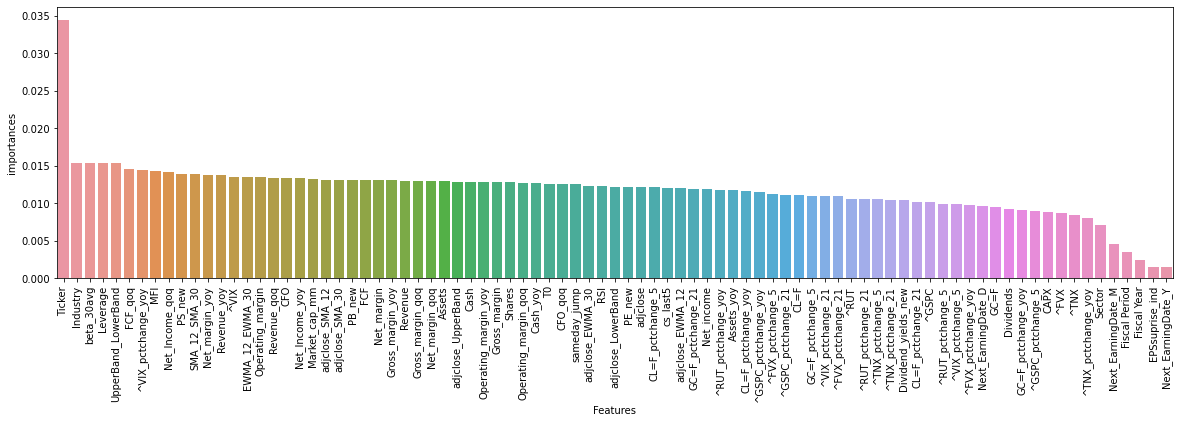

In [120]:
importances = model.feature_importances_
feature_df = pd.DataFrame({'Features':X1_train.columns, 'importances': importances})
feature_df.sort_values('importances', ascending=False, inplace=True)

plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
sns.barplot(x="Features", y= 'importances', data=feature_df)

In [121]:
drop_feats = list(feature_df.loc[feature_df.importances < 0.010]['Features'])

In [129]:
features = list(feature_df.loc[feature_df.importances >= 0.010]['Features'])

In [130]:
len(features)

67

In [123]:
X2 = X1.drop(columns=drop_feats)
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, random_state=1, train_size=0.7)

In [124]:
model_fs = RandomForestClassifier(n_estimators=100, random_state=42)
model_fs.fit(X2_train, y_train)

# sel_rfe_tree = RFE(estimator=model_tree, n_features_to_select=1, step=1)

RandomForestClassifier(random_state=42)

In [125]:
data_scaler = StandardScaler()
data_scaler.fit(X1_train)

# Scale the training and testing data
X1_train_s=data_scaler.transform(X1_train)
X1_test_s=data_scaler.transform(X1_test)

In [126]:
data_scaler = StandardScaler()
data_scaler.fit(X2_train)

# Scale the training and testing data
X2_train_s=data_scaler.transform(X2_train)
X2_test_s=data_scaler.transform(X2_test)

In [135]:
# Predict outcomes for test data set
y_pred = model.predict_proba(X1_test_s)[:,1]

df_result=pd.DataFrame({"Prediction": y_pred, "Actual": y_test.values.ravel()}).sort_values(by=['Prediction'],ascending=False)
df_result[:10]

/Users/hasnainraza/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


,Prediction,Actual
1715,0.69,1.0
1329,0.66,1.0
1540,0.66,1.0
219,0.65,0.0
2049,0.64,1.0
382,0.64,1.0
655,0.64,0.0
1021,0.64,1.0
16,0.64,1.0
2146,0.63,0.0


In [136]:
y_pred2 = model_fs.predict_proba(X2_test_s)[:,1]

df_result_fs=pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).sort_values(by=['Prediction'],ascending=False)
df_result_fs[:10]

/Users/hasnainraza/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


,Prediction,Actual
5950,0.69,1.0
1545,0.66,1.0
190,0.66,1.0
2004,0.65,0.0
646,0.64,1.0
306,0.64,1.0
243,0.64,0.0
1550,0.64,1.0
4757,0.64,1.0
6628,0.63,0.0


In [153]:
df_result.dtypes

Prediction    float64
Actual        float64
dtype: object